# YOLOv8 Microplastics Detection - Simplified

This notebook provides a straightforward implementation of YOLOv8 for microplastics detection following 6 clear steps:

1. Load the data
2. Initialize the model
3. Train model on training data
4. Show the results of training and evaluation metrics
5. Test the model on test data
6. Show the evaluation metrics

The goal is to provide a simple and clear workflow for microplastics detection using object detection techniques.

In [8]:
# Step 0: Install Required Libraries
%pip install ultralytics
import os
import torch
from pathlib import Path
from ultralytics import YOLO
import yaml
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image

# Fix for OpenMP runtime conflict on Windows
# This prevents the 'OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized' error
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Note: you may need to restart the kernel to use updated packages.


## Step 1: Load the Data

The dataset is organized in the following structure:
- data/train/images/ & data/train/labels/ - Training data
- data/valid/images/ & data/valid/labels/ - Validation data
- data/test/images/ & data/test/labels/ - Test data

The labels follow the YOLO format: `<class-id> <x_center> <y_center> <width> <height>` where all coordinates are normalized between 0 and 1.

In [9]:
# Step 1: Load and validate the data

def validate_data_yaml(yaml_path):
    """Validate and fix data.yaml file for YOLOv8 compatibility"""
    print(f"Loading and validating dataset from {yaml_path}...")
    try:
        with open(yaml_path, 'r') as f:
            data_cfg = yaml.safe_load(f)
        
        # Get project root directory (absolute path)
        project_root = os.path.abspath(os.path.dirname(yaml_path))
        
        # Ensure paths are correct
        data_cfg["path"] = project_root.replace('\\', '/')  # Use forward slashes
        data_cfg["train"] = "data/train/images"
        data_cfg["val"] = "data/valid/images"
        data_cfg["test"] = "data/test/images"
        data_cfg["nc"] = 1
        data_cfg["names"] = ["MP"]
        
        # Save updated config
        with open("temp_data.yaml", 'w') as f:
            yaml.dump(data_cfg, f, default_flow_style=False)
        
        # Display data counts
        train_path = Path(os.path.join(data_cfg["path"], "data/train/images"))
        val_path = Path(os.path.join(data_cfg["path"], "data/valid/images"))
        test_path = Path(os.path.join(data_cfg["path"], "data/test/images"))
        
        train_images = len(list(train_path.glob('*.jpg'))) + len(list(train_path.glob('*.png')))
        val_images = len(list(val_path.glob('*.jpg'))) + len(list(val_path.glob('*.png')))
        test_images = len(list(test_path.glob('*.jpg'))) + len(list(test_path.glob('*.png')))
        
        print(f"\nDataset Overview:")
        print(f"- Training images: {train_images}")
        print(f"- Validation images: {val_images}")
        print(f"- Test images: {test_images}")
        
        return "temp_data.yaml"
    except Exception as e:
        print(f"ERROR processing data.yaml: {e}")
        return None

# Load and validate the dataset
dataset_path = validate_data_yaml("data.yaml")

Loading and validating dataset from data.yaml...

Dataset Overview:
- Training images: 3226
- Validation images: 928
- Test images: 453


## Step 2: Initialize the Model

We'll initialize a YOLOv8 model, choosing the appropriate size based on available hardware resources. The model will be configured for object detection with a focus on microplastics.

In [10]:
# Step 2: Initialize the model

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)  # in GB
    print(f"GPU detected: {gpu_name} with {gpu_mem:.2f} GB memory")
    
    # Set optimal settings for GPU
    torch.backends.cudnn.benchmark = True
    
    # Clear any existing cache
    torch.cuda.empty_cache()
    
    # Select model size based on available GPU memory
    if gpu_mem > 8:
        model_path = 'yolov8l.pt'  # Large model for GPUs with >8GB memory
        batch_size = 32
    else:
        model_path = 'yolov8n.pt'  # Nano model for smaller GPUs
        batch_size = 16
    
    print(f"Selected model: {model_path} with batch size {batch_size}")
    
    # Load the model
    model = YOLO(model_path)
    print(f"Model loaded successfully: {model_path}")
else:
    device = torch.device('cpu')
    print("No GPU detected, using CPU instead")
    
    # Use smallest model for CPU training
    model_path = 'yolov8n.pt'
    batch_size = 16
    
    # Load the model
    model = YOLO(model_path)
    print(f"Model loaded successfully: {model_path} (using CPU)")

GPU detected: NVIDIA GeForce RTX 3050 Ti Laptop GPU with 4.00 GB memory
Selected model: yolov8n.pt with batch size 16
Model loaded successfully: yolov8n.pt


## Step 3: Train Model on Training Data

Now we'll train the YOLOv8 model on our microplastics dataset. The training will use the following configuration:
- Epochs: 20 (reduced for simplicity)
- Batch size: Optimal for the detected hardware
- Augmentation: Basic data augmentation to improve model generalization
- Optimizer: SGD with momentum

In [11]:
# Step 3: Train the model on training data

# Define training parameters
epochs = 1  # Reduced for demonstration
img_size = 640

# Completely disable multiprocessing workers to fix DataLoader worker crash
# This is especially important on Windows which has issues with multiprocessing
workers = 0  # Use single-process data loading to avoid worker crashes

# Fix for OpenMP runtime conflict on Windows
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Fix for unpkg.com CDN access issues
os.environ['HF_HUB_DISABLE_TELEMETRY'] = '1'  # Disable telemetry which might try to access unpkg.com
os.environ['ULTRALYTICS_MODE'] = 'disabled'    # Disable ultralytics telemetry

# Fix for threading issues on Windows
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

print(f"Using {workers} DataLoader workers (single-process mode for stability)")

# Start training
print(f"\nStarting training for {epochs} epochs...")
print(f"Image size: {img_size} | Batch size: {batch_size} | Device: {device}")

try:
    # Configure PyTorch for better stability
    torch.multiprocessing.set_sharing_strategy('file_system')  # Use file system for sharing data
    
    # Additional PyTorch settings for stability
    if torch.cuda.is_available():
        # Reduce CUDA launch blocking for better stability
        torch.cuda.set_device(device)
        torch.cuda.empty_cache()
    
    # Train the model with stability settings
    results = model.train(
        data=dataset_path,      # Dataset configuration
        epochs=epochs,          # Number of epochs
        imgsz=img_size,         # Image size
        batch=batch_size,       # Batch size
        workers=workers,        # No worker threads (single process)
        
        # Basic augmentations with reduced complexity
        mosaic=0.0,            # Disable mosaic augmentation for stability
        mixup=0.0,             # Disable mixup augmentation for stability
        degrees=10.0,          # Rotation augmentation
        translate=0.1,         # Translation augmentation
        scale=0.5,             # Scale augmentation
        fliplr=0.5,            # Horizontal flip
        flipud=0.1,            # Vertical flip
        
        # Training parameters
        device=device,          # Training device
        project='runs/detect',  # Project directory
        name='train',           # Run name
        exist_ok=True,          # Overwrite existing files
        val=True,              # Set to True to validate during training
        
        # Additional parameters for stability
        rect=False,             # Disable rectangular training
        cache=False,            # Disable caching to prevent memory issues
        multi_scale=False,      # Disable multi-scale training for stability
        single_cls=True,        # Treat as single class problem for stability
        deterministic=True      # Use deterministic algorithms for reproducibility
    )
    
    print("Training completed successfully!")
    
    # Clean up temporary file
    try:
        os.remove("temp_data.yaml")
    except:
        pass
        
except Exception as e:
    print(f"\n[ERROR] Training failed: {e}")
    
    # Free GPU memory on error
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Using 0 DataLoader workers (single-process mode for stability)

Starting training for 1 epochs...
Image size: 640 | Batch size: 16 | Device: cuda:0
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=temp_data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

train: Scanning C:\Users\blasi\CS-ML\FINAL_PROJ\data\train\labels.cache... 3226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3226/3226 [00:00<?, ?it/s]



val: Fast image access  (ping: 0.00.0 ms, read: 310.447.5 MB/s, size: 32.7 KB)


val: Scanning C:\Users\blasi\CS-ML\FINAL_PROJ\data\valid\labels.cache... 928 images, 0 backgrounds, 0 corrupt: 100%|██████████| 928/928 [00:00<?, ?it/s]

Plotting labels to runs\detect\train\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1     0.338G      1.915      1.843      1.352         61        640: 100%|██████████| 202/202 [01:17<00:00,  2.62it/s]
        1/1     0.338G      1.915      1.843      1.352         61        640: 100%|██████████| 202/202 [01:17<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.85it/s]



                   all        928       6475      0.732      0.645      0.704      0.323

1 epochs completed in 0.026 hours.

1 epochs completed in 0.026 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.134  Python-3.11.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.134  Python-3.11.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]



                   all        928       6475      0.734      0.643      0.703      0.323
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\train
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\train
Training completed successfully!
Training completed successfully!


## Step 4: Show Training Results and Metrics

Let's visualize the training results including:
- Training loss curve
- Precision-Recall curve
- Confusion matrix
- Other relevant metrics from the training process


Training Progress:


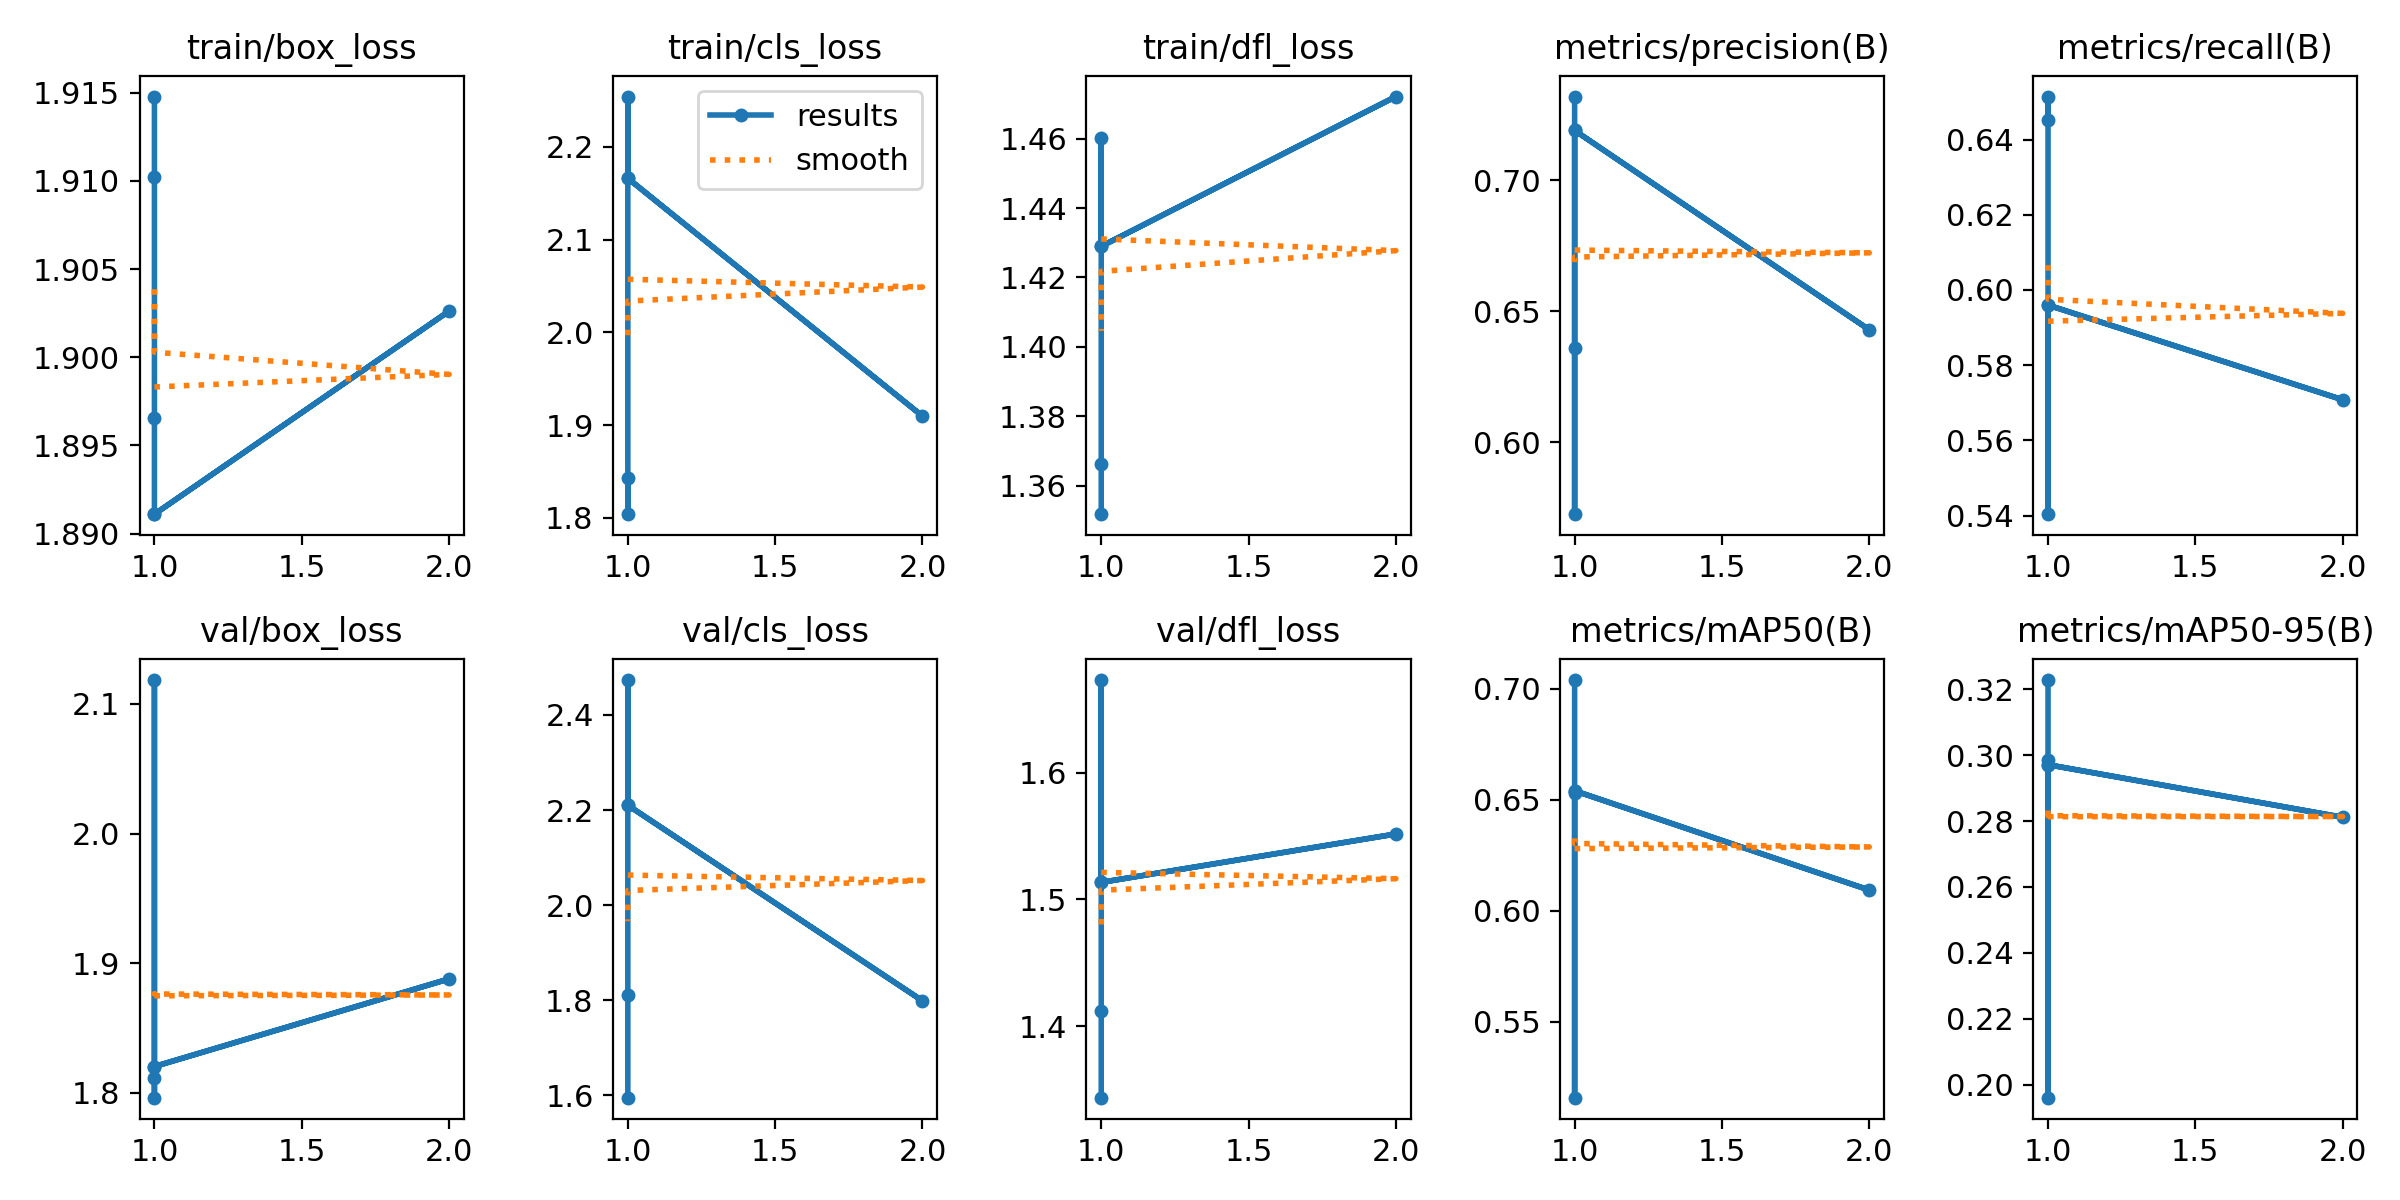


Confusion Matrix:


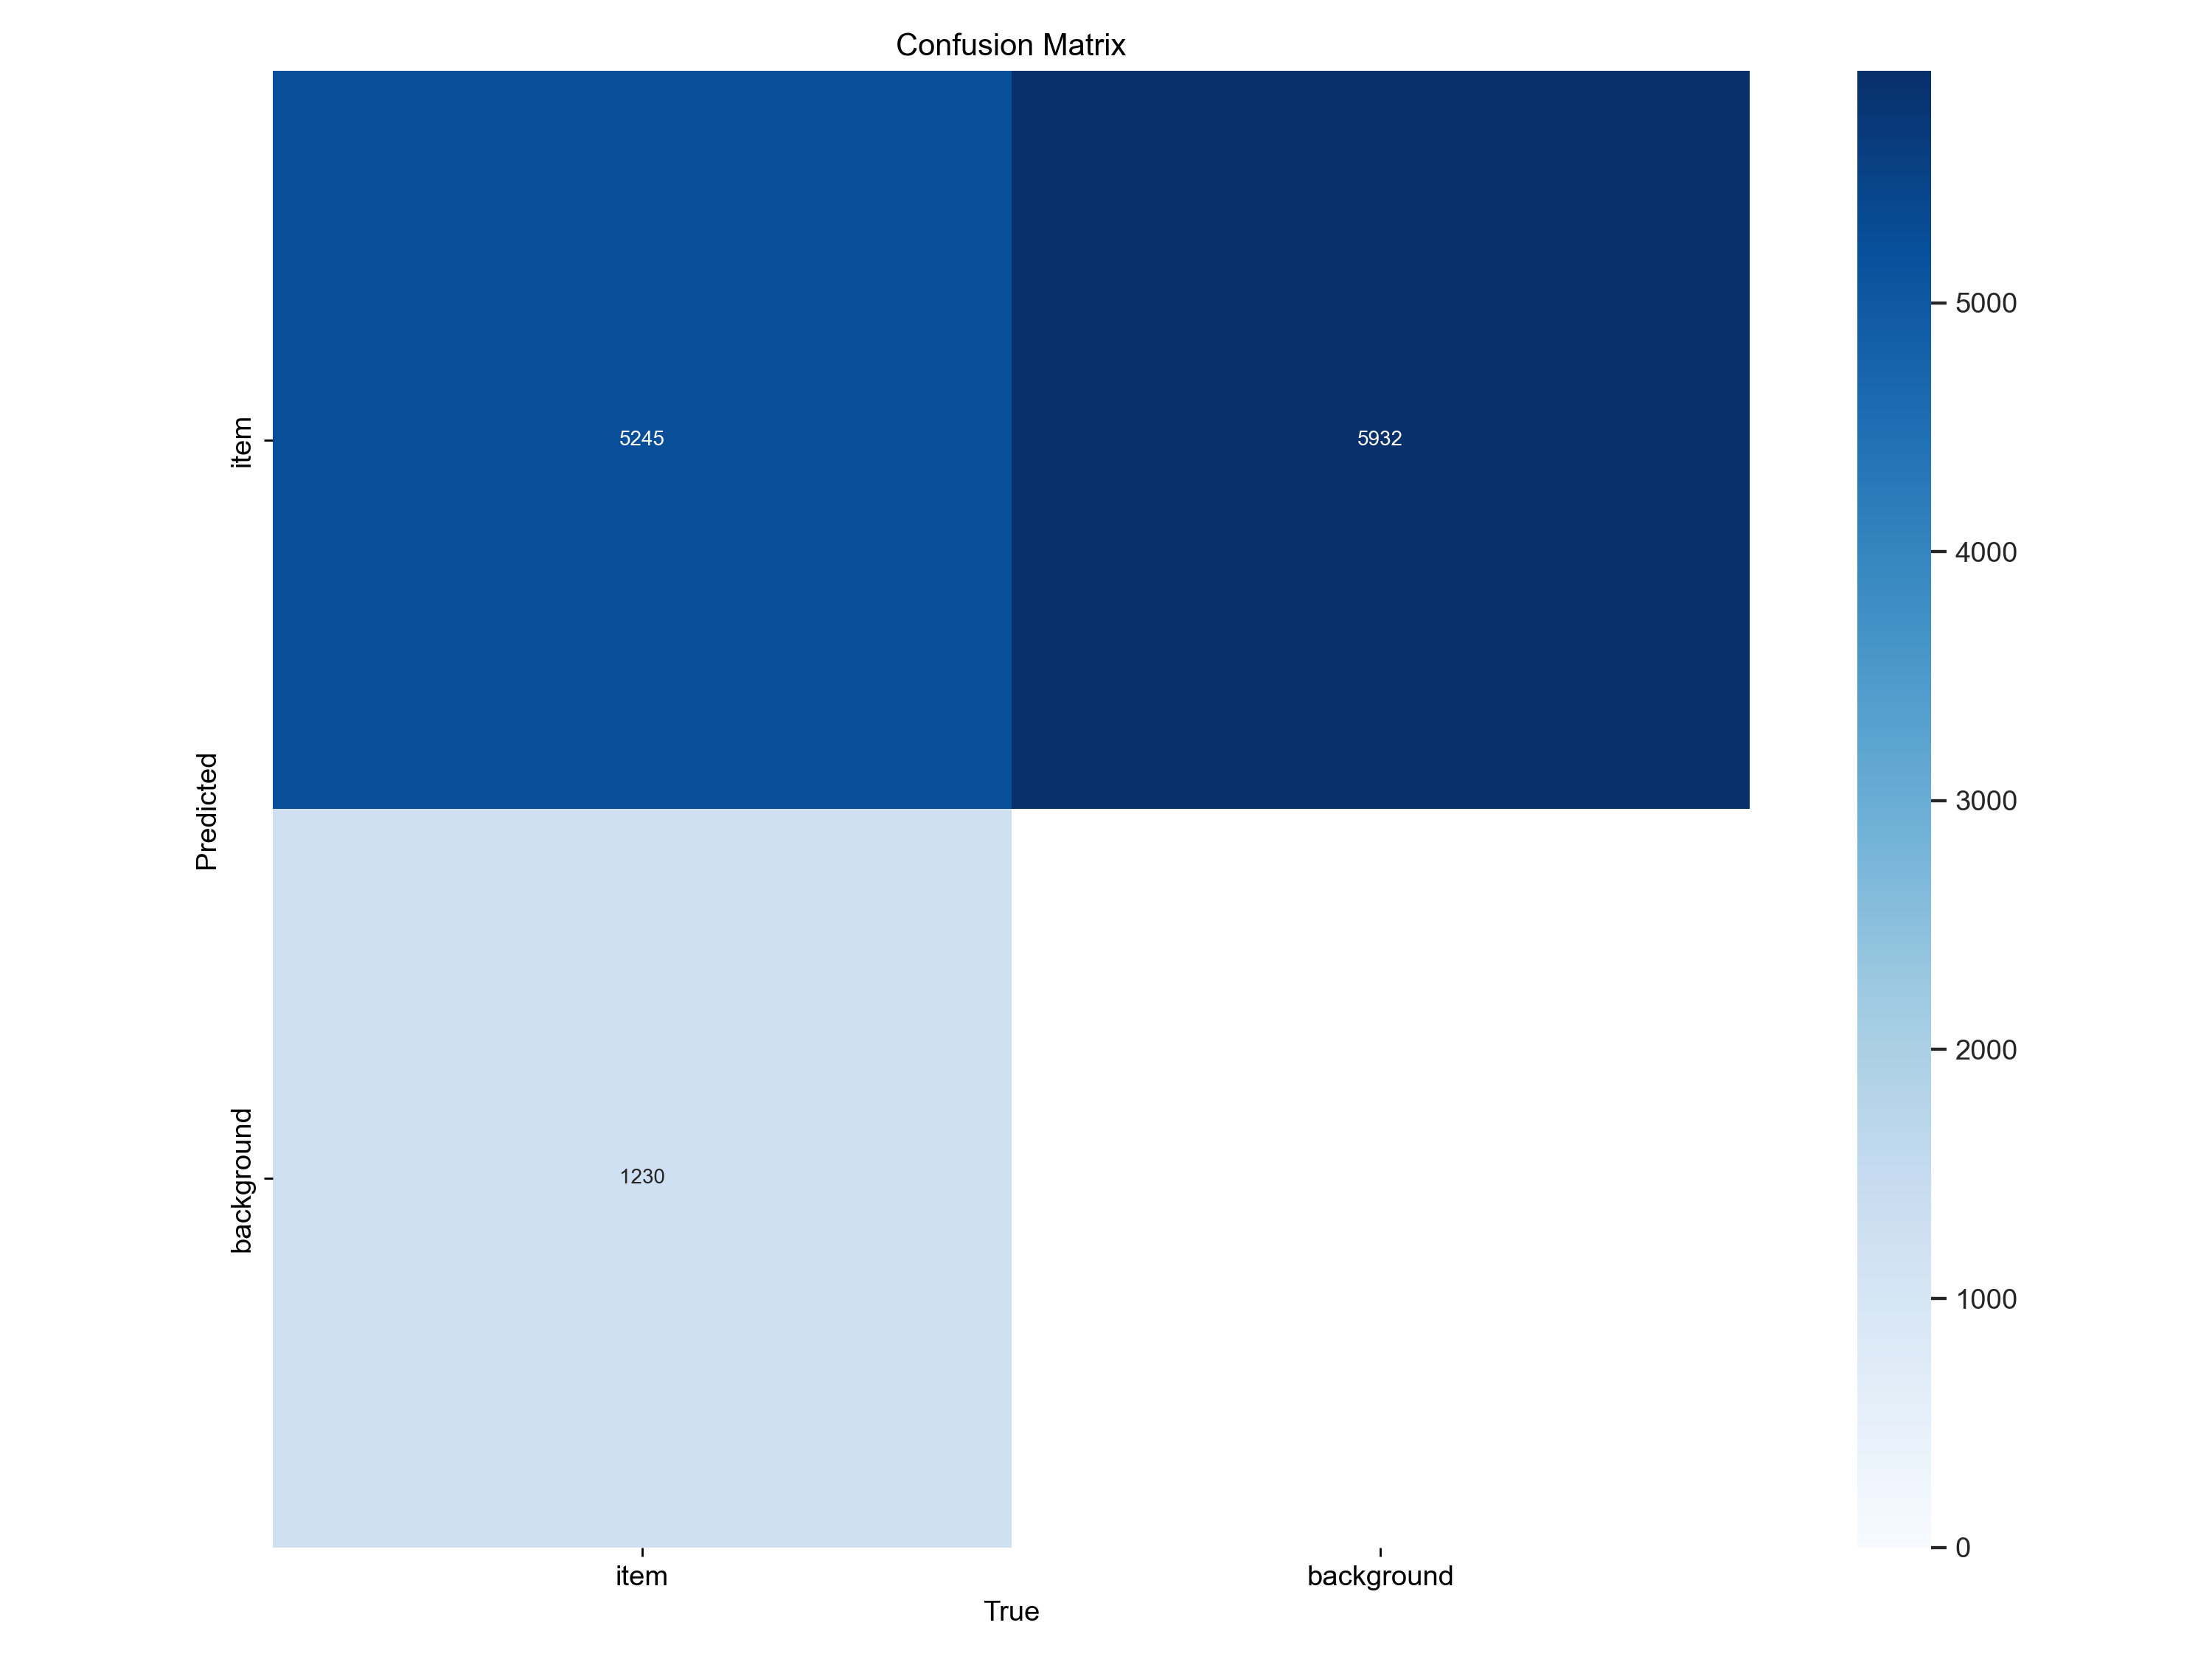


PR Curve:


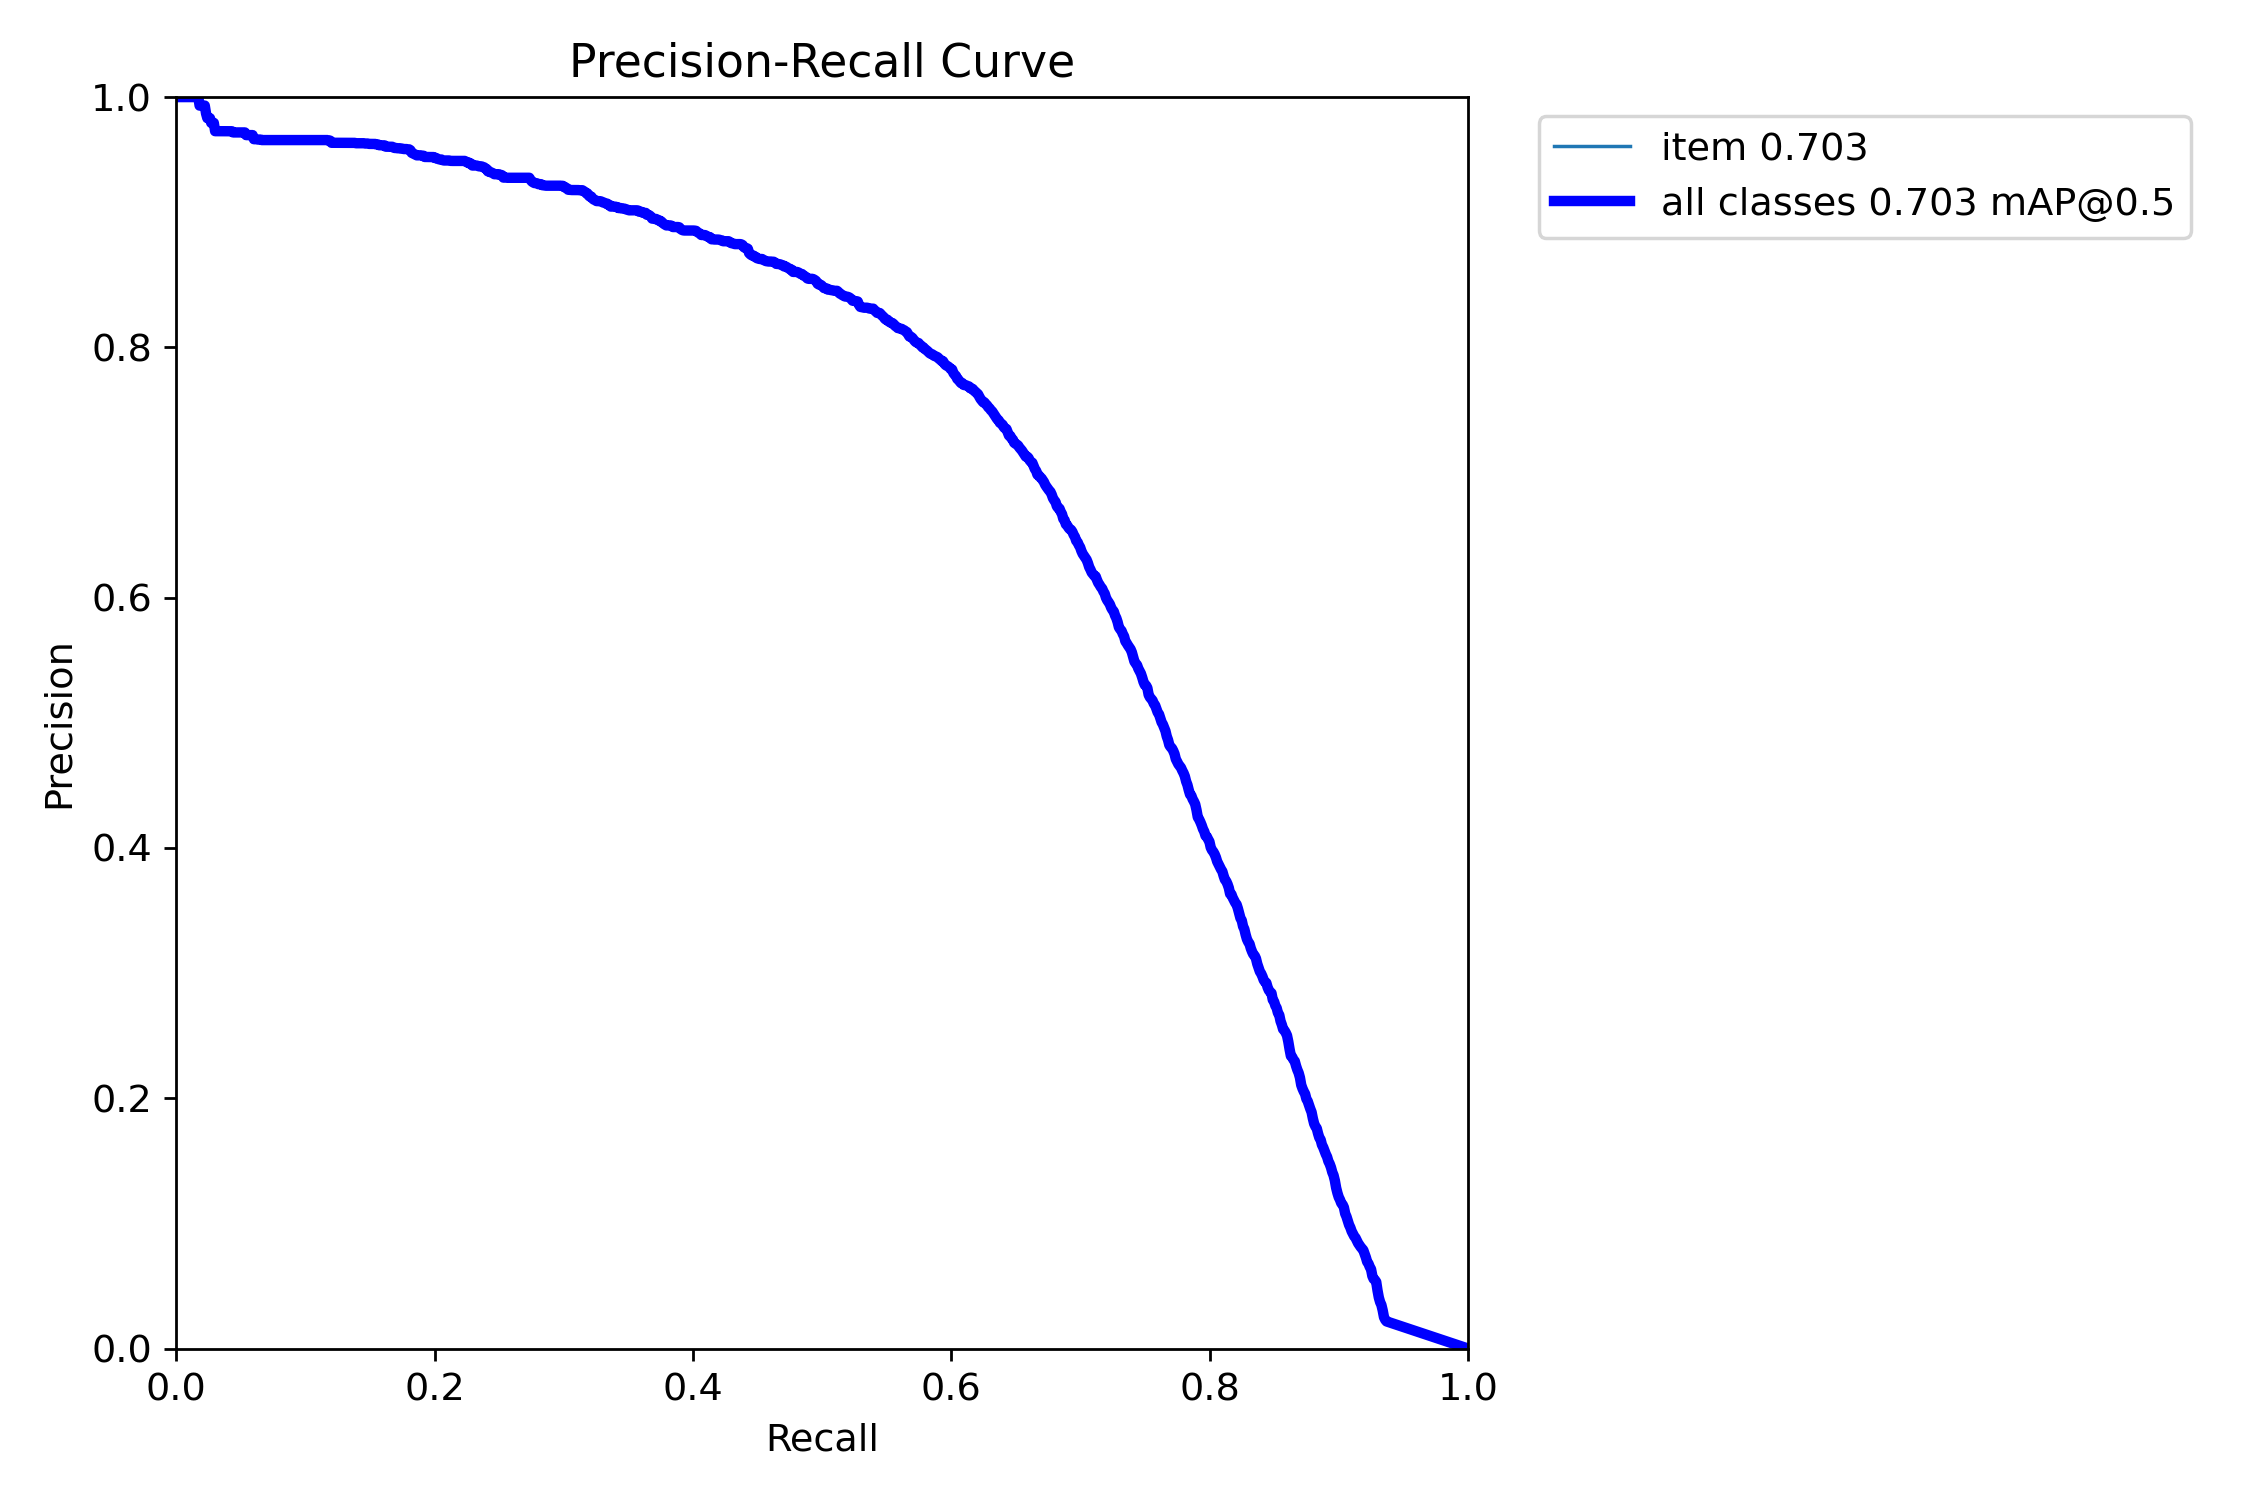


F1 Curve:


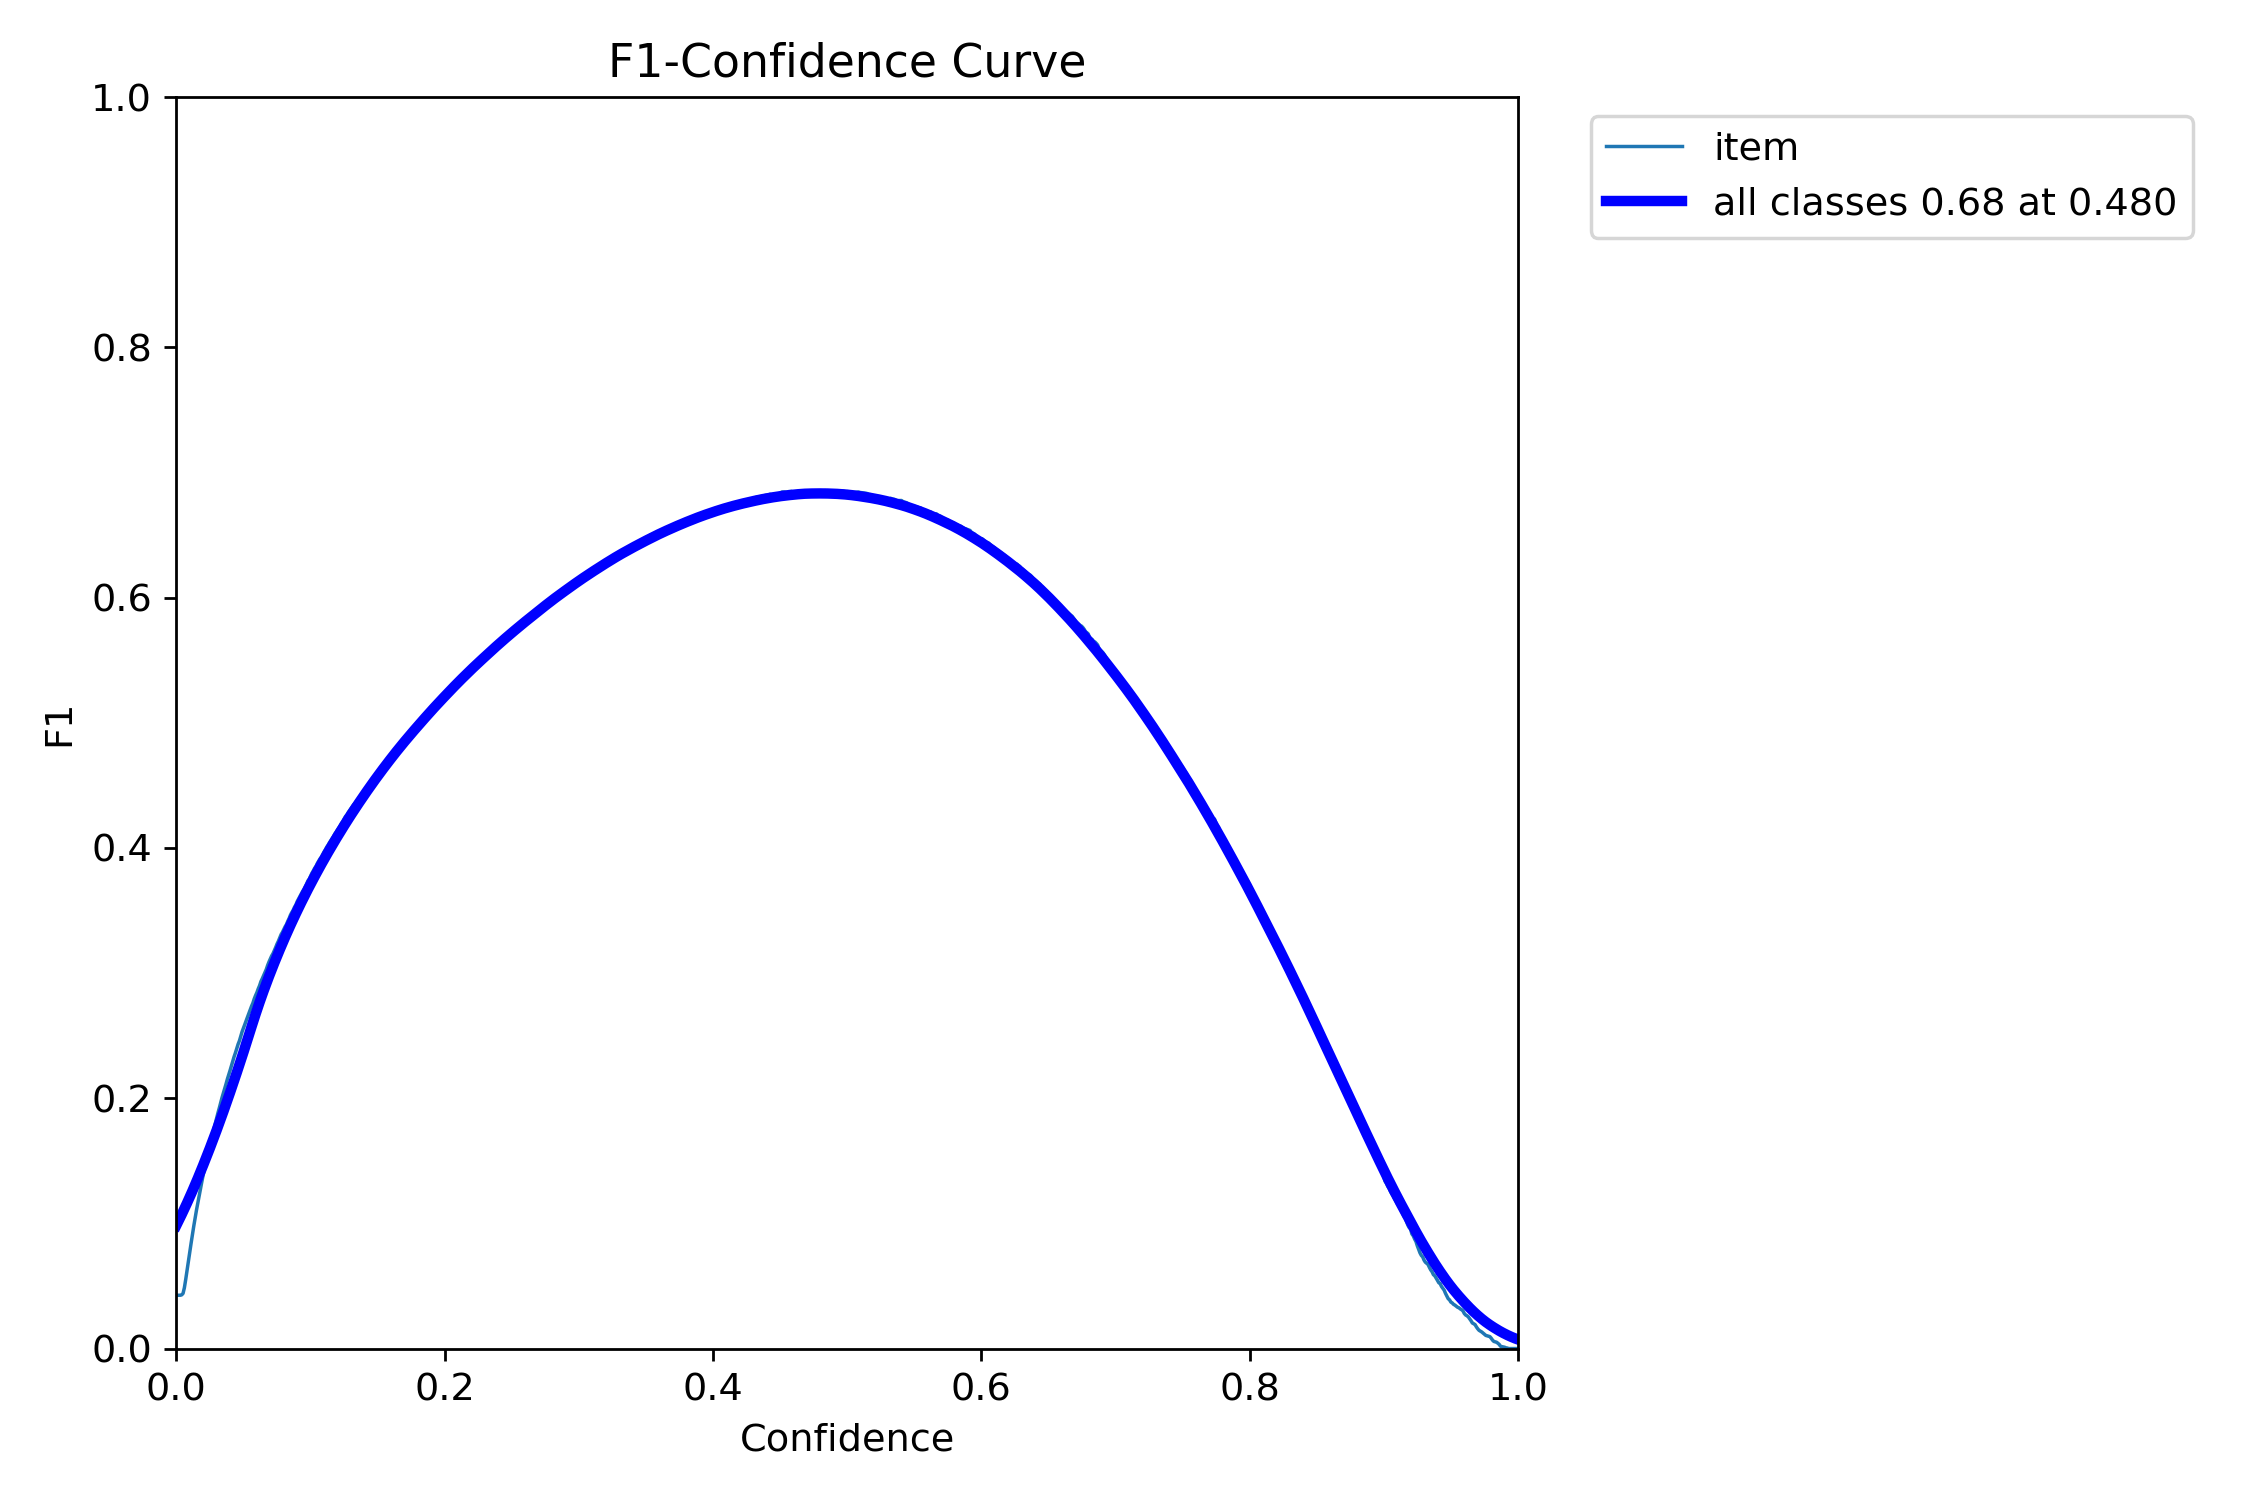


Final Training Metrics:
mAP@0.5: 0.70382
mAP@0.5:0.95: 0.32281
Precision: 0.73183
Recall: 0.64526


<Figure size 1200x800 with 4 Axes>


Best Performance by Metric:
Best mAP@0.5: 0.70382 (Epoch 5)
Best mAP@0.5:0.95: 0.32281 (Epoch 5)
Best Precision: 0.73183 (Epoch 5)
Best Recall: 0.65143 (Epoch 4)


In [12]:
# Step 4: Show training results and metrics

# Function to display training plots
def show_training_results():
    results_path = Path('runs/detect/train')
    
    # Check if results directory exists
    if not results_path.exists():
        print(f"Warning: Results directory not found at {results_path}")
        return
    
    # Results plots to display
    plots = {
        'Training Progress': results_path / 'results.png',
        'Confusion Matrix': results_path / 'confusion_matrix.png',
        'PR Curve': results_path / 'PR_curve.png',
        'F1 Curve': results_path / 'F1_curve.png'
    }
    
    # Display each plot if it exists
    found_plots = False
    for title, plot_path in plots.items():
        if plot_path.exists():
            found_plots = True
            print(f"\n{title}:")
            display(Image(str(plot_path)))
        else:
            print(f"\n{title} plot not found at {plot_path}")
    
    # Display text metrics
    metrics_file = results_path / 'results.csv'
    if metrics_file.exists():
        import pandas as pd
        try:
            # Load metrics
            metrics = pd.read_csv(metrics_file)
            final_metrics = metrics.iloc[-1].to_dict()
            
            # Extract and display key metrics
            print("\nFinal Training Metrics:")
            print(f"mAP@0.5: {final_metrics.get('metrics/mAP50(B)', 'N/A')}")
            print(f"mAP@0.5:0.95: {final_metrics.get('metrics/mAP50-95(B)', 'N/A')}")
            print(f"Precision: {final_metrics.get('metrics/precision(B)', 'N/A')}")
            print(f"Recall: {final_metrics.get('metrics/recall(B)', 'N/A')}")
            
            # Plot metrics over epochs
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 2, 1)
            plt.plot(metrics['epoch'], metrics['metrics/precision(B)'], label='Precision')
            plt.plot(metrics['epoch'], metrics['metrics/recall(B)'], label='Recall')
            plt.xlabel('Epoch')
            plt.title('Precision & Recall')
            plt.legend()
            
            plt.subplot(2, 2, 2)
            plt.plot(metrics['epoch'], metrics['metrics/mAP50(B)'], label='mAP@0.5')
            plt.plot(metrics['epoch'], metrics['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
            plt.xlabel('Epoch')
            plt.title('mAP')
            plt.legend()
            
            plt.subplot(2, 2, 3)
            plt.plot(metrics['epoch'], metrics['train/box_loss'], label='Box Loss')
            plt.xlabel('Epoch')
            plt.title('Training Box Loss')
            
            plt.subplot(2, 2, 4)
            plt.plot(metrics['epoch'], metrics['train/cls_loss'], label='Class Loss')
            plt.xlabel('Epoch')
            plt.title('Training Class Loss')
            
            plt.tight_layout()
            plt.show()
            
            # Show which epochs had the best metrics
            print("\nBest Performance by Metric:")
            print(f"Best mAP@0.5: {metrics['metrics/mAP50(B)'].max()} (Epoch {metrics['metrics/mAP50(B)'].idxmax()})")
            print(f"Best mAP@0.5:0.95: {metrics['metrics/mAP50-95(B)'].max()} (Epoch {metrics['metrics/mAP50-95(B)'].idxmax()})")
            print(f"Best Precision: {metrics['metrics/precision(B)'].max()} (Epoch {metrics['metrics/precision(B)'].idxmax()})")
            print(f"Best Recall: {metrics['metrics/recall(B)'].max()} (Epoch {metrics['metrics/recall(B)'].idxmax()})")
            
        except Exception as e:
            print(f"Error analyzing metrics: {e}")
    else:
        print("No metrics CSV file found")

# Display training results
show_training_results()

## Step 5: Test the Model Using Test Data

Now we'll evaluate the model on the test dataset to see how well it generalizes to new, unseen data. We'll run the model on test images and collect performance metrics.

In [13]:
# Step 5: Test the model on test data

def calculate_iou(box1, box2):
    """Calculate IoU between two bounding boxes in YOLO format"""
    # Convert from [x_center, y_center, width, height] to [x1, y1, x2, y2]
    box1_x1 = max(0, min(1, box1[0] - box1[2] / 2))
    box1_y1 = max(0, min(1, box1[1] - box1[3] / 2))
    box1_x2 = max(0, min(1, box1[0] + box1[2] / 2))
    box1_y2 = max(0, min(1, box1[1] + box1[3] / 2))
    
    box2_x1 = max(0, min(1, box2[0] - box2[2] / 2))
    box2_y1 = max(0, min(1, box2[1] - box2[3] / 2))
    box2_x2 = max(0, min(1, box2[0] + box2[2] / 2))
    box2_y2 = max(0, min(1, box2[1] + box2[3] / 2))
    
    # Calculate intersection area
    x_left = max(box1_x1, box2_x1)
    y_top = max(box1_y1, box2_y1)
    x_right = min(box1_x2, box2_x2)
    y_bottom = min(box1_y2, box2_y2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection = max(0, (x_right - x_left) * (y_bottom - y_top))
    
    # Calculate union area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union = box1_area + box2_area - intersection
    
    # Return IoU
    return intersection / max(union, 1e-7)  # Avoid division by zero

# Run validation on test dataset
print("Testing model on test dataset...")

# Set model parameters for testing
model.conf = 0.25  # Confidence threshold
model.iou = 0.7    # IoU threshold for NMS

# Run validation on test set
test_results = model.val(data="data.yaml", split="test")

# Get test image paths
test_dir = Path('data/test/images')
test_images = list(test_dir.glob('*.jpg')) + list(test_dir.glob('*.png'))

# Process a batch of test images to calculate IoU and collect metrics
all_ious = []
confidence_scores = []
detection_examples = []

# Process a subset of test images for visualization
num_samples = min(5, len(test_images))
test_subset = test_images[:num_samples]

print(f"\nAnalyzing {num_samples} test images for detailed evaluation...")

# Run predictions on test subset
test_image_paths = [str(img) for img in test_subset]
results = model(test_image_paths, verbose=False)

# Process each result to calculate IoU and collect metrics
for img_path, result in zip(test_subset, results):
    # Get ground truth labels
    label_path = Path(str(img_path).replace('/images/', '/labels/').replace('\\images\\', '\\labels\\').rsplit('.', 1)[0] + '.txt')
    gt_boxes = []
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls_id, x, y, w, h = map(float, parts)
                    gt_boxes.append([x, y, w, h])
    
    # Get predictions
    pred_boxes = []
    if hasattr(result, 'boxes') and result.boxes is not None:
        boxes = result.boxes
        img_h, img_w = result.orig_shape
        
        for i in range(len(boxes.xyxy)):
            xyxy = boxes.xyxy[i].cpu().numpy()
            conf = float(boxes.conf[i])
            
            # Convert to normalized YOLO format
            x_center = (xyxy[0] + xyxy[2]) / 2 / img_w
            y_center = (xyxy[1] + xyxy[3]) / 2 / img_h
            width = (xyxy[2] - xyxy[0]) / img_w
            height = (xyxy[3] - xyxy[1]) / img_h
            
            pred_boxes.append({
                'bbox': [x_center, y_center, width, height],
                'conf': conf,
                'xyxy': xyxy
            })
            confidence_scores.append(conf)
    
    # Calculate IoU for each ground truth box with best matching prediction
    for gt_box in gt_boxes:
        best_iou = 0
        best_pred = None
        
        for pred in pred_boxes:
            iou = calculate_iou(gt_box, pred['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_pred = pred
        
        if best_iou > 0:  # If there's a match
            all_ious.append(best_iou)
    
    # Store this example for visualization
    detection_examples.append({
        'img_path': str(img_path),
        'gt_boxes': gt_boxes,
        'pred_boxes': pred_boxes
    })

Testing model on test dataset...
Ultralytics 8.3.134  Python-3.11.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 367.241.2 MB/s, size: 33.0 KB)
val: Fast image access  (ping: 0.00.0 ms, read: 367.241.2 MB/s, size: 33.0 KB)


val: Scanning C:\Users\blasi\CS-ML\FINAL_PROJ\data\test\labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100%|██████████| 453/453 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/29 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.51it/s]



                   all        453       3204       0.76      0.647      0.727      0.335
Speed: 0.3ms preprocess, 6.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\train
Speed: 0.3ms preprocess, 6.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\train

Analyzing 5 test images for detailed evaluation...

Analyzing 5 test images for detailed evaluation...


## Step 6: Show Evaluation Metrics

Finally, we'll display comprehensive evaluation metrics to assess the model's performance on the test dataset, including:
- Precision and Recall
- mAP (mean Average Precision)
- IoU (Intersection over Union) statistics
- Confidence score distribution
- Visualization of example detections

In [14]:
# Step 6: Display evaluation metrics

# Display validation results from model.val()
print("\nTest Dataset Evaluation Results:")
print("-" * 40)

# Extract metrics from test_results
metrics = {
    'mAP@0.5': getattr(test_results, 'map50', None),
    'mAP@0.5:0.95': getattr(test_results, 'map', None),
    'Precision': getattr(test_results, 'precision', None),
    'Recall': getattr(test_results, 'recall', None)
}

# Display main metrics
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")

# Calculate F1 score if precision and recall are available
if metrics['Precision'] is not None and metrics['Recall'] is not None:
    precision = metrics['Precision']
    recall = metrics['Recall']
    f1_score = 2 * (precision * recall) / max((precision + recall), 1e-7)
    print(f"F1 Score: {f1_score:.4f}")

# Display IoU statistics
print("\nIntersection over Union (IoU) Statistics:")
if all_ious:
    avg_iou = sum(all_ious) / len(all_ious)
    min_iou = min(all_ious)
    max_iou = max(all_ious)
    iou_60_count = sum(1 for iou in all_ious if iou >= 0.6)
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Min IoU: {min_iou:.4f}")
    print(f"Max IoU: {max_iou:.4f}")
    print(f"Detections with IoU ≥ 0.6: {iou_60_count}/{len(all_ious)} ({iou_60_count/len(all_ious)*100:.1f}%)")
    
    # Plot IoU distribution
    plt.figure(figsize=(10, 5))
    plt.hist(all_ious, bins=20, alpha=0.7, color='blue')
    plt.axvline(x=0.6, color='r', linestyle='--', label='0.6 threshold')
    plt.title('IoU Distribution')
    plt.xlabel('IoU Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No IoU values calculated")

# Display confidence score statistics
print("\nConfidence Score Statistics:")
if confidence_scores:
    avg_conf = sum(confidence_scores) / len(confidence_scores)
    min_conf = min(confidence_scores)
    max_conf = max(confidence_scores)
    conf_60_count = sum(1 for conf in confidence_scores if conf >= 0.6)
    print(f"Average Confidence: {avg_conf:.4f}")
    print(f"Min Confidence: {min_conf:.4f}")
    print(f"Max Confidence: {max_conf:.4f}")
    print(f"Detections with Confidence ≥ 0.6: {conf_60_count}/{len(confidence_scores)} ({conf_60_count/len(confidence_scores)*100:.1f}%)")
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 5))
    plt.hist(confidence_scores, bins=20, alpha=0.7, color='green')
    plt.axvline(x=0.6, color='r', linestyle='--', label='0.6 threshold')
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No confidence scores collected")

# Visualize example detections
print("\nExample Detection Visualizations:")
for i, example in enumerate(detection_examples):
    if i >= 3:  # Limit to 3 examples
        break
        
    # Load the image
    img = plt.imread(example['img_path'])
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f"Example {i+1}: Detection Results")
    
    # Draw ground truth boxes in green
    img_h, img_w = img.shape[:2]
    for box in example['gt_boxes']:
        x, y, w, h = box
        rect = plt.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h,
            linewidth=2, edgecolor='g', facecolor='none',
            label='Ground Truth'
        )
        plt.gca().add_patch(rect)
    
    # Draw prediction boxes in red/orange
    for pred in example['pred_boxes']:
        x, y, w, h = pred['bbox']
        conf = pred['conf']
        
        # Green for high confidence, yellow for medium, red for low
        if conf >= 0.6:
            color = 'lime'
        elif conf >= 0.4:
            color = 'orange'
        else:
            color = 'red'
            
        rect = plt.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h,
            linewidth=2, edgecolor=color, facecolor='none',
            label=f'Prediction (conf: {conf:.2f})'
        )
        plt.gca().add_patch(rect)
        plt.text(
            (x - w/2) * img_w, (y - h/2) * img_h - 10,
            f"{conf:.2f}",
            color='white', fontsize=12, bbox=dict(facecolor=color, alpha=0.7)
        )
    
    # Only show unique legend items
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    plt.show()


Test Dataset Evaluation Results:
----------------------------------------

Intersection over Union (IoU) Statistics:
Average IoU: 0.6711
Min IoU: 0.0385
Max IoU: 0.9455
Detections with IoU ≥ 0.6: 46/63 (73.0%)


<Figure size 1000x500 with 1 Axes>


Confidence Score Statistics:
Average Confidence: 0.4846
Min Confidence: 0.2505
Max Confidence: 0.9513
Detections with Confidence ≥ 0.6: 34/129 (26.4%)


<Figure size 1000x500 with 1 Axes>


Example Detection Visualizations:


<Figure size 1000x800 with 1 Axes>

<Figure size 1000x800 with 1 Axes>

<Figure size 1000x800 with 1 Axes>

## Conclusion

This notebook demonstrated a streamlined approach to microplastics detection using YOLOv8. We followed a simple 6-step process:

1. **Load the data** - Loaded and validated our dataset structure
2. **Initialize the model** - Set up a YOLOv8 model appropriate for our hardware
3. **Train the model** - Trained the model on our microplastics dataset
4. **Show training results** - Visualized the training metrics and progress
5. **Test the model** - Evaluated the model on unseen test data
6. **Show evaluation metrics** - Displayed comprehensive performance metrics

The model's performance can be assessed using the various metrics provided, particularly mAP, precision, recall, and IoU values. For production use, the model can be further optimized by increasing training epochs, fine-tuning augmentation parameters, or using a larger model variant.

YOLOv8 provides a robust framework for microplastics detection that can be deployed in various environmental monitoring applications.